## Note only core cod is included here:
#### Create clusters using % TV comsumption
#### Where to find the segment in digital world?
#### Test whether the clusters are different from each other 
#### Name the clusters

In [2]:
# import packages

import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import warnings
import sys
import os
from io import StringIO
import shutil


## kmeans with 30 clusters

In [3]:
pct=pd.read_csv(WF+'00_pct.csv')

IDs=pct[['ip_address','dma','weight']]
raw_array=pct.values[:,3:]
print(raw_array.shape)

(4260238, 96)


In [4]:
from sklearn.cluster import KMeans

km1=KMeans(n_clusters=30)
km=km1.fit_predict(raw_array)
lbl=pd.DataFrame(km)
lbl.columns=['Label']
lbl['ct']=1
lbl[:3]

,Label,ct
0,26,1
1,19,1
2,12,1


In [5]:
center=pd.DataFrame(km1.cluster_centers_)
center=center.values
center=np.transpose(center)
center.shape

(96, 30)

In [10]:
#center=pd.DataFrame(center)
center['Network']=list(pct.columns)[3:]
center.to_csv(WF+'02_cluster_center.csv')
center[:4]

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Network
0,0.012483,0.017945,0.086502,0.356191,0.027293,0.038123,0.008931,0.035221,0.029465,0.012149,...,0.011938,0.015614,0.081002,0.023366,0.036546,0.037932,0.010749,0.008924,0.010273,Nw|CBS
1,0.014999,0.017318,0.359640,0.081176,0.028592,0.043292,0.008671,0.030791,0.031318,0.011042,...,0.010916,0.012655,0.083914,0.024143,0.036092,0.024788,0.009864,0.011049,0.013488,Nw|NBC
2,0.012150,0.016151,0.079057,0.071667,0.834183,0.037051,0.007188,0.031859,0.024791,0.010515,...,0.008678,0.012140,0.346658,0.017824,0.027813,0.026050,0.009002,0.008744,0.010900,Nw|ABC
3,0.011117,0.019340,0.055877,0.054886,0.016855,0.657769,0.007606,0.015327,0.028050,0.007907,...,0.007607,0.009449,0.054637,0.016549,0.011018,0.021738,0.006797,0.018207,0.012748,Nw|FOX


In [12]:
lblr=lbl.values
tv=pct[['ip_address','dma','weight']].values
tv_lbl=np.c_[tv,lblr]
tv_lbl.shape
tv_lbl=pd.DataFrame(tv_lbl)
tv_lbl.columns=['ip_address','dma','weight','Label','ct']
tv_lbl.to_csv(WF+'02_TV_ID_Label.csv',index=False)
tv_lbl[:3]

,ip_address,dma,weight,Label,ct
0,11bbe2cacb0796c5c52c3d21b9d12b61,Houston,23.6959,26,1
1,17d36b6b30c6d5a69519e151e0961b1d,New York,34.3753,19,1
2,8a86e492e665129baa1b5c23c797997d,Yuma-El Centro,17.3255,12,1


In [13]:
lbl_ct=tv_lbl.groupby('Label',as_index=False)['ip_address'].count()
lbl_ct=lbl_ct.sort_values('ip_address',ascending=False)
lbl_ct['lbl_pct']=lbl_ct['ip_address']/lbl_ct['ip_address'].sum()
lbl_ct.to_csv(WF+'02_lbl_count.csv',index=False)
print(lbl_ct['lbl_pct'].sum())
print(lbl_ct[:5])

1.0
    Label  ip_address   lbl_pct
19     19     1572774  0.369175
2       2      281833  0.066154
3       3      279698  0.065653
23     23      269750  0.063318
26     26      199849  0.046910


# label and quintile and digital consumption

In [24]:
# look at pct of visiting the site between different labels
ls=lbl_site.groupby(['label','ptle'],as_index=False)[[x+'_dv' for x in sites]].mean()
ls2=[]
for s in sites:
    tmp=ls[['label','ptle',s+'_dv']]
    tmp=tmp.rename(columns={s+'_dv':'visit_rate'})
    tmp['site']=s
    if type(ls2)==list:
        ls2=tmp
    else:
        ls2=pd.concat([ls2,tmp])
ls2.to_csv(WF+'02_lbl_ptle_site_dv.csv',index=False)
ls2[:3]

,label,ptle,visit_rate,site
0,0,1,0.135236,yahoo_com
1,0,2,0.117852,yahoo_com
2,0,3,0.104518,yahoo_com


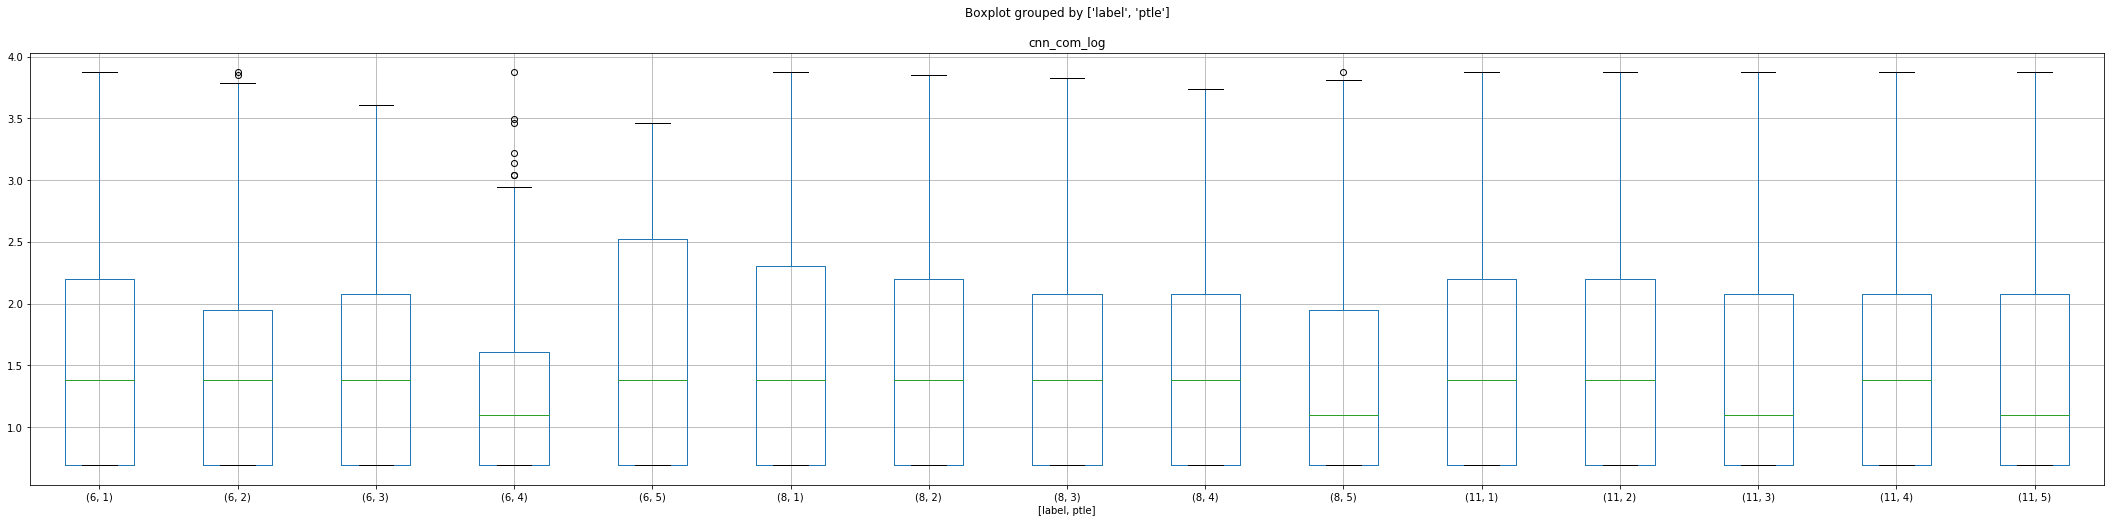

In [26]:
import math
s='cnn_com'
tmp=lbl_site.copy()
tmp[s+'_log']=tmp[s].map(lambda x: math.log(x+1))  #natural log without base
tmp=tmp[tmp[s+'_log']>0]
th=np.percentile(tmp[s+'_log'],95)
tmp=tmp[tmp[s+'_log']<th]
tmp[tmp['label'].isin([6,8,11])].boxplot(s+'_log', by=['label','ptle'], figsize=(36, 8))

### Test how different each clusteer is

In [28]:
#pair-wise test
import scipy

out2=[]
tmp=lbl_site.copy()
tmp['hk']=tmp['ptle']*100+tmp['label']
HK=tmp['hk'].unique()
for st in ['cnn_com','Overall']:# sites:
    print(st)
    for i in range(0,len(HK)):
        for j in range(i+1,len(HK)):
            tst=scipy.stats.kruskal(tmp[tmp['hk']==HK[i]][st],tmp[tmp['hk']==HK[j]][st])
            out2.append([st,i,j,tst.pvalue])

cnn_com
Overall


In [29]:
out_2=pd.DataFrame(out2,columns=['site','hk1','hk2','p-value'])
out_2.to_csv(WF+'02_lbl_site_pvalue_2.csv',index=False)
out_2[:3]

,site,hk1,hk2,p-value
0,cnn_com,0,1,7.031038e-135
1,cnn_com,0,2,3.031688e-50
2,cnn_com,0,3,5.529807e-01


### Name cluster using top networks they watch (absolutely and relatively) and top programs they watch

In [40]:
#Relative viewership
nw_cpy=nw.copy()
nw_cpy["rk"] = nw_cpy.groupby("label",as_index=False)["sec_pct"].rank("dense", ascending=False)
nw_cpy=nw_cpy[(nw_cpy['rk']<=5)]

nw_cpy=nw_cpy.pivot(index='label',columns='rk',values=['network','sec_pct'])

nw_cpy.to_csv(WF+'03_Label_Networks.csv')
nw_cpy[:3]

network                                                         \
rk          1.0        2.0             3.0       4.0               5.0   
label                                                                    
0      Nw|HBOHD  Nw|HBO2HD       Nw|HBOCHD  Nw|MAXHD        Nw|ACMAXHD   
1      Nw|TBSHD    Nw|CCHD      Nw|TVLNDHD  Nw|PARHD          Nw|FXXHD   
2        Nw|NBC     Nw|PBS  Nw|MyNetworkTV    Nw|CBS  Pgm|NFL Football   

        sec_pct                                               
rk          1.0        2.0        3.0        4.0         5.0  
label                                                         
0      0.101891  0.0878642  0.0656089   0.023603   0.0231231  
1      0.143198  0.0150259  0.0136622  0.0105714  0.00922573  
2       0.36448   0.114866   0.100839  0.0920202   0.0860254

In [42]:
# Absolute viewership
nw2=nw[['label','network','sec','wvs','unique']]
gp2=nw2.groupby('label',as_index=False)['sec'].sum()
gp2=gp2.rename(columns={'sec':'sec_lbl'})
nw2=nw2.merge(gp2,how='inner',on=['label'])
nw2['sec_pct']=nw2['sec']/nw2['sec_lbl']

nw2['rk']=nw2.groupby('label',as_index=False)['sec_pct'].rank("dense",ascending=False)
nw2=nw2[nw2['rk']<=6]

nw2=nw2.pivot(index='label',columns='rk',values=['network','sec_pct'])

nw2.to_csv(WF+'03_Label_networks_absolute.csv')
nw2[:3]

network                                                              \
rk          1.0        2.0        3.0       4.0               5.0       6.0   
label                                                                         
0      Nw|HBOHD  Nw|HBO2HD  Nw|HBOCHD    Nw|CBS            Nw|NBC    Nw|ABC   
1      Nw|TBSHD    Nw|CCHD     Nw|CBS  Nw|NIKHD            Nw|ABC    Nw|FOX   
2        Nw|NBC     Nw|CBS     Nw|ABC    Nw|FOX  Pgm|NFL Football  Nw|HGTVD   

        sec_pct                                                         
rk          1.0        2.0        3.0        4.0        5.0        6.0  
label                                                                   
0      0.342923   0.196232  0.0637096  0.0221123  0.0202793  0.0190518  
1       0.46451  0.0266693  0.0245684  0.0212777  0.0196183  0.0196029  
2      0.342346   0.088842  0.0735814  0.0515681  0.0266494  0.0221258

In [48]:
# Top programs they watch
pgm2=pgm[(pgm['rk_sec']<=50)]

pgm2=pgm2.pivot(index='label',columns='rk_sec',values='title')
pgm2=pgm2[list(range(1,51))]

pgm2.to_csv(WF+'03_Label_Programs.csv')
pgm2[:2]

rk_sec,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
label,,,,,,,,,,,,,,,,,,,,,
0,True Detective,Ready Player One,Oceans 8,Game of Thrones,Deadpool 2,The Sopranos,Real Time With Bill Maher,Tag,NFL Football,Life of the Party,...,Maze Runner: The Death Cure,College Basketball,Self/less,The Mummy,Wonder Woman,Sex and the City 2,Anchorman: The Legend of Ron Burgundy,SportsCenter,The Book of Eli,NBA Basketball
1,Friends,The Big Bang Theory,The King of Queens,American Dad,Family Guy,Everybody Loves Raymond,Seinfeld,2 Broke Girls,Bobs Burgers,NFL Football,...,Doctor Strange,Criminal Minds,How I Met Your Mother,Roseanne,Diners Drive-Ins and Dives,Men in Black,NCIS,PGA Tour Golf,Chicago P.D.,Supernatural
